In [1]:
from mylib.statistic_test import *

code_id = "0859 - Fit Retrieval Moment with Pure Behavior"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)

dir_name = join(figpath, "Dsp", "Reforming Neural Trajectory Analysis")

"""
Keys of PKL Files:
    {
        'neural_traj': neural_traj,
        'pos_traj': pos_traj,
        'time_traj': time_traj,
        'route_traj': route_traj,
        'lap_traj': lap_traj,
        'session_traj': session_traj,
        'speed_traj': speed_traj,
        'len_traj': len_traj,
        'perfect_traj': perfect_traj,
        'decoded_idx_traj': decoded_idx_traj,
        'decoded_corr_traj': decoded_corr_traj,
        'loss_traj': loss_traj,
        'smoothed_loss_traj': smoothed_loss_traj,
        'retriv_state_traj': retriv_state_traj,
                    
        'behav_traj': behav_traj,
        'behav_lap_traj': behav_lap_traj,
        'behav_route_traj': behav_route_traj,
        'behav_session_traj': behav_session_traj,
        'behav_to_ms_traj': behav_to_ms_traj
    }
"""
pass

def get_data(mouse: int):
    with open(join(dir_name, f"{mouse}.pkl"), "rb") as f:
        data = pickle.load(f)
    return data

        E:\Data\FinalResults\Dsp\0859 - Fit Retrieval Moment with Pure Behavior is already existed!


# Grid Search for Best Retrospective Integration Window

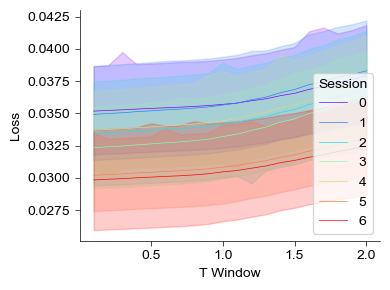

In [2]:
def integral_behavior(behav_lap_traj: np.ndarray, behav_traj: np.ndarray, t_window: float) -> np.ndarray:
    """
    Parameters
    ----------
    behav_traj : np.ndarray, shape (12, n_behav_frames)
        Dim 0: Allocentric X (cm)
        Dim 1: Allocentric Y (cm)
        Dim 2: Allocentric Heading Angle (rad)
        Dim 3: Ego-centric X (cm)
        Dim 4: Ego-centric Y (cm)
        Dim 5: Ego-centric Heading Angle (rad)
        Dim 6: Time (s)
        Dim 7: X Displacement (cm)
        Dim 8: Y Displacement (cm)
        Dim 9: Speed (cm/s)
        Dim 10: Angular Speed (rad/s)
        Dim 11: Time Interval (s)
    t_window : float
        The time window for integration. Unit: s
        
    Returns
    -------
    integral_traj : np.ndarray, shape (3, n_behav_frames)
        Dim 0: Recent Runing Distance (cm)
        Dim 1: Recent Displacement (cm)
        Dim 2: Recent Ego-centric Heading Angle (rad)
    """
    beg = np.concatenate([[0], np.where(np.diff(behav_lap_traj) != 0)[0] + 1])
    end = np.concatenate([beg[1:], [behav_lap_traj.shape[0]]])
    
    integral_traj = np.zeros((3, behav_lap_traj.shape[0]))
    
    for i in range(len(beg)):
        beg_idx = beg[i]
        end_idx = end[i]
        
        if end_idx - beg_idx < 2:
            continue
        
        dt_a, dt_b = np.meshgrid(behav_traj[6, beg_idx:end_idx], behav_traj[6, beg_idx:end_idx])
        is_integrable = np.where((dt_a - dt_b >= -t_window) & (dt_a - dt_b <= 0), 1, 0)
           
        integral_traj[0, beg_idx:end_idx] = (is_integrable @ (behav_traj[9, beg_idx:end_idx] * behav_traj[11, beg_idx:end_idx])[:, np.newaxis])[:, 0]
        dx = is_integrable @ behav_traj[7, beg_idx:end_idx][:, np.newaxis]
        dy = is_integrable @ behav_traj[8, beg_idx:end_idx][:, np.newaxis]
        integral_traj[1, beg_idx:end_idx] = np.sqrt(dx**2 + dy**2)[:, 0]
        integral_traj[2, beg_idx:end_idx] = (is_integrable @ (behav_traj[10, beg_idx:end_idx] * behav_traj[11, beg_idx:end_idx])[:, np.newaxis])[:, 0]
        
    return integral_traj

def matrix_decomposition(neural_traj: np.ndarray, behav_traj: np.ndarray, lambda_reg=1e-5) -> np.ndarray:
    """
    Parameters
    ----------
    neural_traj (M): np.ndarray, shape (n_neurons, n_neural_frames)
        Neural Trajectory
    behav_traj (B): np.ndarray, shape (12+3, n_neural_frames)
        Behavioral Parameters
        !!! Note that the behavioral parameters should be aligned with the neural trajectory.
        So please use behav_to_ms_traj to align the behavioral parameters with the neural trajectory
        prior to calling this function.
    lambda_reg : float, optional
        Regularization parameter for the Frobenius norm. The default is 1e-5.
        
    Returns
    -------
    D: Matrix to perform dimensionality reduction on neural trajectory.
    loss: Frobenius norm of the difference B - D @ M.
    
    Notes
    -----
    The matrix decomposition is performed as follows:
        B = D @ M + loss
    """
    # Neural Trajectory
    M = neural_traj
    B = behav_traj
    
    N, T = M.shape
    C, _ = B.shape
    
    MMt = M @ M.T + lambda_reg * np.eye(N)
    D = B @ M.T @ np.linalg.inv(MMt)
    
    loss = np.linalg.norm(B - D @ M)
    
    return D, loss, B, M

def get_svd(D: np.ndarray, M: np.ndarray) -> tuple:
    """
    Parameters
    ----------
    D : np.ndarray, shape (C, N)
        Matrix to perform dimensionality reduction on neural trajectory.
    M : np.ndarray, shape (N, T)
        Neural Trajectory
        
    Returns
    -------
    U : np.ndarray, shape (C, C)
        Left singular vectors of D.
    S : np.ndarray, shape (C, C)
        Singular values of D.
    Vt : np.ndarray, shape (C, N)
        Right singular vectors of D.
    
    Notes
    -----
    The SVD is performed as follows:
        D = U @ S @ Vt
    """
    U, S, Vt = np.linalg.svd(D @ M, full_matrices=False)
    return U, S, Vt

if exists(join(figdata, f"{code_id} [select best time window].pkl")) == False:
    t_windows = np.linspace(0.1, 2, 20)
    
    LossData = {
        "MiceID": [],
        "Session": [],
        "T Window": [],
        "Loss": []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        res = get_data(mouse)
        behav_lap_traj = res["behav_lap_traj"]
        behav_traj = res["behav_traj"]
        neural_traj = res["neural_traj"]
        behav_to_ms_traj = res["behav_to_ms_traj"]
        session_traj = res["session_traj"]
        retriv_state_traj = res["retriv_state_traj"]
        
        print(mouse, '---------------')
        for s in range(7):
            print(f" S{s+1}")
            for t in tqdm(t_windows):
                idx = np.where((session_traj == s))[0]
                integral_traj = integral_behavior(behav_lap_traj=behav_lap_traj, behav_traj=behav_traj, t_window=t)
                behav_concat_traj = np.concatenate([behav_traj, integral_traj], axis=0)
                behav_concat_traj_aligned = behav_concat_traj[:, behav_to_ms_traj]
                neural_traj_i = neural_traj[:, idx]
                behav_concat_traj_i = behav_concat_traj_aligned[:, idx]
                
                D, loss, B, M = matrix_decomposition(neural_traj=neural_traj_i, behav_traj=behav_concat_traj_i)
                LossData["MiceID"].append(mouse)
                LossData["Session"].append(s)
                LossData["T Window"].append(t)
                LossData["Loss"].append(loss/M.shape[1]/15)
                
    for k in LossData.keys():
        LossData[k] = np.array(LossData[k])
    
    with open(join(figdata, f"{code_id} [select best time window].pkl"), "wb") as f:
        pickle.dump(LossData, f)
        
    LossD = pd.DataFrame(LossData)
    LossD.to_excel(join(figdata, f"{code_id} [select best time window].xlsx"), index=False)
    
    print(len(LossD))
else:
    with open(join(figdata, f"{code_id} [select best time window].pkl"), "rb") as f:
        LossData = pickle.load(f)

fig = plt.figure(figsize=(4, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    data=LossData,
    x="T Window",
    y="Loss",
    hue="Session",
    palette='rainbow',
    ax=ax,
    lw=0.5,
)
plt.tight_layout()
plt.savefig(join(loc, "Losses vs. t.png"), dpi=600)
plt.savefig(join(loc, "Losses vs. t.svg"), dpi=600)
plt.show()

# Variance

10212 ---------------


100%|██████████| 7/7 [00:09<00:00,  1.32s/it]


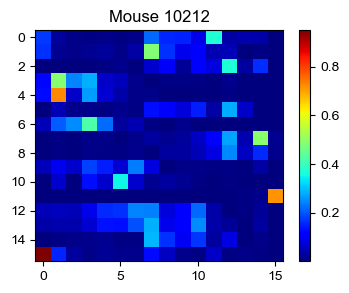

10224 ---------------


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


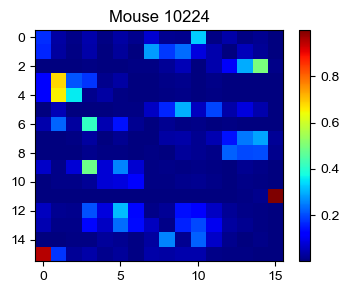

10227 ---------------


100%|██████████| 7/7 [00:20<00:00,  2.86s/it]


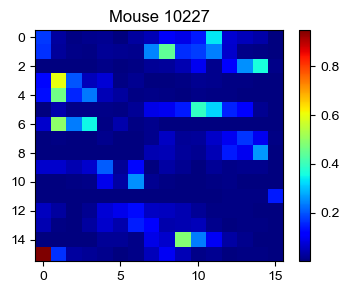

10232 ---------------


100%|██████████| 7/7 [00:09<00:00,  1.43s/it]


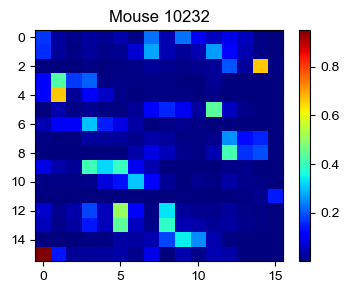

448


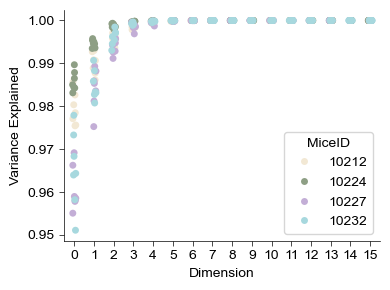

In [12]:
def compute_variance_explained(D: np.ndarray, M: np.ndarray) -> np.ndarray:
    """
    Parameters
    ----------
    D : np.ndarray, shape (12+3, N)
        Matrix to perform dimensionality reduction on neural trajectory.
    M : np.ndarray, shape (N, T)
        Neural Trajectory
        
    Returns
    -------
    variance_explained : np.ndarray, shape (C, C)
        Variance explained by each component.
    
    Notes
    -----
    The variance explained is computed as follows:
        variance_explained = S^2 / sum(S^2)
    """
    M_centered = M - M.mean(axis=1, keepdims=True)
    Sigma_M = (M_centered @ M_centered.T) / (M.shape[1]-1)
    total_variance = np.trace(Sigma_M)
    
    DMc = D @ M_centered
    
    Sigma_DMc = (DMc @ DMc.T) / (M.shape[1]-1)

    U, S, Vt = np.linalg.svd(DMc, full_matrices=False)
    explained_fractions = np.cumsum(S**2) / np.sum(S**2)
        
    return explained_fractions
 
if exists(join(figdata, f"{code_id}  [Variance Explained].xlsx")) == False:
    VarianceData = {
        "MiceID": [],
        "Session": [],
        "Dimension": [],
        "Variance Explained": []
    }
    
    DD = GetDMatrices(1, 48)
    
    t_window = 1
    
    for mouse in [10212, 10224, 10227, 10232]:
        U_ = np.zeros((16, 16))
        res = get_data(mouse)
        behav_lap_traj = res["behav_lap_traj"]
        behav_traj = res["behav_traj"]
        neural_traj = res["neural_traj"]
        behav_to_ms_traj = res["behav_to_ms_traj"]
        session_traj = res["session_traj"]
        pos_traj = res["pos_traj"]
        print(mouse, '---------------')
        for s in tqdm(range(7)):
            nodes = (behav_traj[0, :] / 2).astype(int) + (behav_traj[1, :] / 2).astype(int) * 48
            integral_traj = integral_behavior(behav_lap_traj=behav_lap_traj, behav_traj=behav_traj, t_window=t_window)
            behav_concat_traj = np.concatenate([behav_traj, integral_traj, DD[:1, nodes]], axis=0)
            behav_concat_traj_aligned = behav_concat_traj[:, behav_to_ms_traj]
            neural_traj_i = neural_traj[:, session_traj == s]
            behav_concat_traj_i = behav_concat_traj_aligned[:, session_traj == s]
                
            D, loss, B, M = matrix_decomposition(neural_traj=neural_traj_i, behav_traj=behav_concat_traj_i)
            U, S, Vt = np.linalg.svd(D@M, full_matrices=False)
            U_ += U
            explained_fractions = compute_variance_explained(D=D, M=M)
                
            VarianceData["MiceID"].append(np.repeat(mouse, D.shape[0]))
            VarianceData["Session"].append(np.repeat(s, D.shape[0]))
            VarianceData["Dimension"].append(np.arange(D.shape[0]))
            VarianceData["Variance Explained"].append(explained_fractions)
        
        fig = plt.figure(figsize=(4, 3))
        ax = plt.axes()
        im = ax.imshow(np.abs(U_/7), cmap='jet', aspect='auto')
        plt.colorbar(im, ax=ax)
        ax.set_title(f"Mouse {mouse}")
        plt.savefig(join(loc, f"SVD - U [{mouse}].svg"), dpi=600)
        plt.show()
    
    for k in VarianceData.keys():
        VarianceData[k] = np.concatenate(VarianceData[k])
        
    with open(join(figdata, f"{code_id} [Variance Explained].pkl"), "wb") as f:
        pickle.dump(VarianceData, f)
        
    VarianceD = pd.DataFrame(VarianceData)
    VarianceD.to_excel(join(figdata, f"{code_id} [Variance Explained].xlsx"), index=False)
    print(len(VarianceD))
else:
    with open(join(figdata, f"{code_id} [Variance Explained].pkl"), "rb") as f:
        VarianceData = pickle.load(f)
        
fig = plt.figure(figsize=(4, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    data=VarianceData,
    x="Dimension",
    y="Variance Explained",
    hue="MiceID",
    ax=ax,
    palette=MicePaletteDSP,
    
)
plt.tight_layout()
plt.savefig(join(loc, "Explained Variance.png"), dpi=600)
plt.savefig(join(loc, "Explained Variance.svg"), dpi=600)
plt.show()

# Is Explained Variance Depending on Time.